In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
!pip install DateTime
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [6]:
# Print all of the classes mapped to the Base

# I chose to get the classes with the inspector tool
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find measurement columns with inspector
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find station columns with inspector
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [12]:
# Calculate the date one year from the last date in data set.
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Start Date: ", start_date)


Start Date:  2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
# Without using the startdate variable
results = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date >= dt.datetime(2016, 8, 23)).\
                  order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurement_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
measurement_df.head()



,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


Text(0, 0.5, 'Inches')

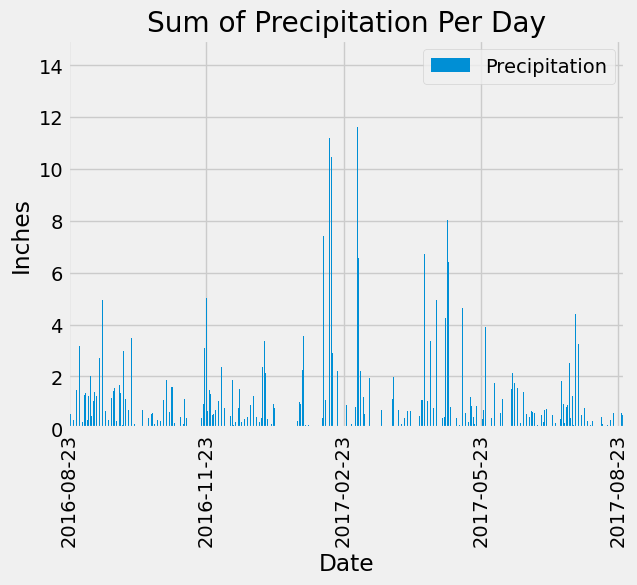

In [14]:
# Group by each day and find total precipitation for that day.
grouped_df = measurement_df.groupby('Date')
grouped_df = grouped_df.sum('Precipitation')
grouped_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipplot = grouped_df.plot.bar(title='Sum of Precipitation Per Day', xticks=[0, 90, 180 ,270, 360])
precipplot.set_xticklabels(['2016-08-23', '2016-11-23', '2017-02-23', '2017-05-23', '2017-08-23'])
precipplot.set_xlabel("Date")
precipplot.set_ylabel("Inches")


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurement_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [17]:
# List all stations and their counts
results = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
temp_stats = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()

temp_stats

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Query the last 12 months of temperature observation data for the most active station
temp_results = session.query(Measurement.date, Measurement.tobs).\
                  filter(Measurement.date >= dt.datetime(2016, 8, 23)).\
                  filter(Measurement.station == "USC00519281").all()

# Add query results to a new dataframe
temperature_df = pd.DataFrame(temp_results, columns=['Date', 'Temperature'])
temperature_df.head()

,Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


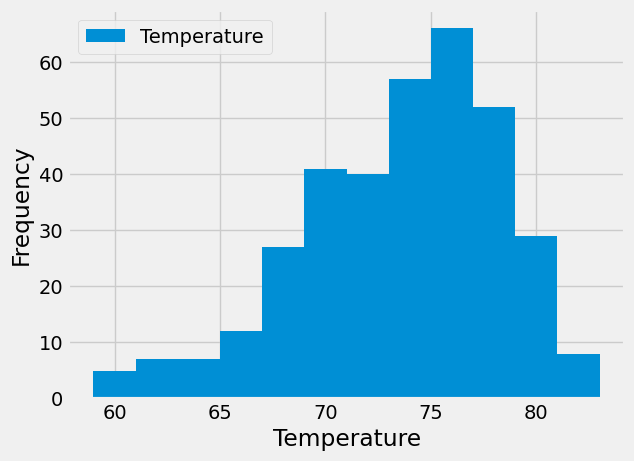

In [20]:
# Plot the results as a histogram
Temphist = temperature_df.plot.hist(bins=12)
Temphist.set_xlabel("Temperature")
Temphist.set_ylabel("Frequency")
plt.show()

# Close Session

In [21]:
# Close Session
session.close()
